<a href="https://colab.research.google.com/github/OinamChitaranjan/mask_detection/blob/main/face_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Debugging Note:**
The model initially showed >80% accuracy during training, but gave highly incorrect predictions when used in real-time.

After investigation, the issue was due to incorrect input preprocessing.

**✅ Fix 1 – cv2.cvtColor:**
OpenCV reads images in BGR format, but the model was trained on RGB images.
Converting with cv2.cvtColor(image, cv2.COLOR_BGR2RGB) fixed this mismatch.

✅ Fix 2 – np.expand_dims: **bold text**
The model expects a batch dimension (shape [1, 128, 128, 3]).
Using np.expand_dims(image, axis=0) ensured the input shape matched the model's requirement.

After applying both fixes, the model produced accurate and reliable predictions.

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:

!kaggle datasets download -d omkargurav/face-mask-dataset

Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
 78% 127M/163M [00:00<00:00, 1.33GB/s]
100% 163M/163M [00:00<00:00, 1.22GB/s]


In [ ]:
# extracting the compessed Dataset
from zipfile import ZipFile
dataset = '/content/face-mask-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [ ]:
!ls

data  drive  face-mask-dataset.zip  kaggle.json  sample_data


**Importing the Dependencies**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.model_selection import train_test_split

In [ ]:
with_mask_files = os.listdir('/content/data/with_mask')
print(with_mask_files[0:5])
print(with_mask_files[-5:])

['with_mask_3266.jpg', 'with_mask_1016.jpg', 'with_mask_1556.jpg', 'with_mask_2605.jpg', 'with_mask_3494.jpg']
['with_mask_722.jpg', 'with_mask_2724.jpg', 'with_mask_1512.jpg', 'with_mask_1716.jpg', 'with_mask_2083.jpg']


In [ ]:
without_mask_files = os.listdir('/content/data/without_mask')
print(without_mask_files[0:5])
print(without_mask_files[-5:])

['without_mask_243.jpg', 'without_mask_2690.jpg', 'without_mask_621.jpg', 'without_mask_1677.jpg', 'without_mask_137.jpg']
['without_mask_868.jpg', 'without_mask_1451.jpg', 'without_mask_2436.jpg', 'without_mask_2669.jpg', 'without_mask_941.jpg']


In [ ]:
print('Number of with mask images:', len(with_mask_files))
print('Number of without mask images:', len(without_mask_files))

Number of with mask images: 3725
Number of without mask images: 3828


In [ ]:
# create the labels

with_mask_labels = [1]*3725

without_mask_labels = [0]*3828

In [ ]:
print(with_mask_labels[0:5])

print(without_mask_labels[0:5])

[1, 1, 1, 1, 1]
[0, 0, 0, 0, 0]


In [ ]:
print(len(with_mask_labels))
print(len(without_mask_labels))

3725
3828


In [ ]:
labels = with_mask_labels + without_mask_labels

print(len(labels))
print(labels[0:5])
print(labels[-5:])

7553
[1, 1, 1, 1, 1]
[0, 0, 0, 0, 0]


**Displaying the Images**

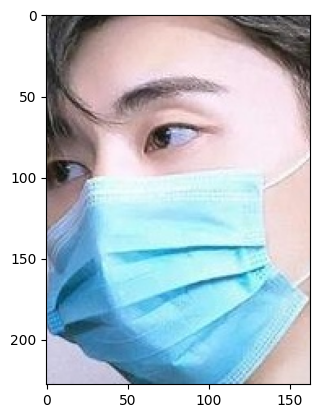

In [ ]:
# displaying with mask image
img = mpimg.imread('/content/data/with_mask/with_mask_1545.jpg')
imgplot = plt.imshow(img)
plt.show()

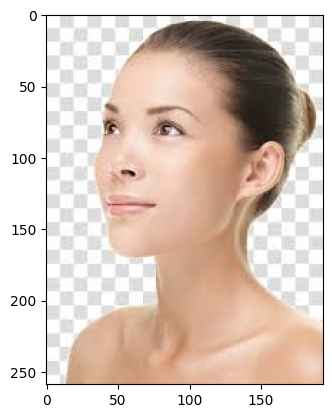

In [ ]:
# displaying without mask image
img = mpimg.imread('/content/data/without_mask/without_mask_2925.jpg')
imgplot = plt.imshow(img)
plt.show()

**Image Processing**

1. Resize the Images

2. Convert the images to numpy arrays

In [ ]:
# convert images to numpy arrays+

with_mask_path = '/content/data/with_mask/'

data = []

for img_file in with_mask_files:

  image = Image.open(with_mask_path + img_file)
  image = image.resize((128,128))
  image = image.convert('RGB')
  image = np.array(image)
  data.append(image)



without_mask_path = '/content/data/without_mask/'


for img_file in without_mask_files:

  image = Image.open(without_mask_path + img_file)
  image = image.resize((128,128))
  image = image.convert('RGB')
  image = np.array(image)
  data.append(image)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
type(data)

list

In [ ]:
len(data)

7553

array([[[199, 124,  61],
        [191, 123,  62],
        [114, 103,  79],
        ...,
        [ 97, 103,  45],
        [ 95, 103,  44],
        [ 94, 104,  44]],

       [[196, 126,  61],
        [191, 123,  60],
        [124, 104,  80],
        ...,
        [100, 104,  47],
        [ 95, 103,  44],
        [ 93, 103,  43]],

       [[196, 125,  61],
        [197, 127,  62],
        [130, 101,  71],
        ...,
        [106, 107,  51],
        [100, 106,  48],
        [ 94, 104,  45]],

       ...,

       [[232,  58,  72],
        [231,  62,  76],
        [232,  68,  85],
        ...,
        [133, 131,  90],
        [135, 133,  92],
        [139, 137,  94]],

       [[232,  49,  71],
        [230,  59,  75],
        [229,  61,  75],
        ...,
        [137, 134,  90],
        [138, 135,  93],
        [142, 138,  95]],

       [[231,  34,  61],
        [232,  51,  70],
        [230,  58,  72],
        ...,
        [138, 135,  92],
        [140, 138,  94],
        [145, 141,  94]]], dtype=uint8)
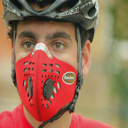

In [ ]:
data[0]

In [ ]:
type(data[0])

numpy.ndarray

In [ ]:
data[0].shape

(128, 128, 3)

In [ ]:
# converting image list and label list to numpy arrays

X = np.array(data)
Y = np.array(labels)

In [ ]:
type(X)

numpy.ndarray

In [ ]:
type(Y)

numpy.ndarray

In [ ]:
print(X.shape)
print(Y.shape)

(7553, 128, 128, 3)
(7553,)


In [ ]:
print(Y)

[1 1 1 ... 0 0 0]


**Train Test Split**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2,stratify=Y)

In [ ]:
print(X.shape, X_train.shape, X_test.shape)

(7553, 128, 128, 3) (6042, 128, 128, 3) (1511, 128, 128, 3)


In [ ]:
# scaling the data

X_train_scaled = X_train/255

X_test_scaled = X_test/255


array([[[217, 168, 110],
        [218, 167, 110],
        [220, 168, 110],
        ...,
        [251, 252, 246],
        [251, 252, 244],
        [250, 253, 246]],

       [[220, 171, 113],
        [220, 169, 112],
        [222, 170, 113],
        ...,
        [252, 253, 245],
        [252, 253, 245],
        [251, 254, 247]],

       [[223, 172, 117],
        [222, 171, 114],
        [224, 172, 115],
        ...,
        [252, 253, 245],
        [253, 255, 244],
        [252, 255, 246]],

       ...,

       [[ 35,  27,  48],
        [ 35,  30,  50],
        [ 41,  36,  56],
        ...,
        [ 79,  80, 111],
        [ 78,  79, 110],
        [ 77,  78, 109]],

       [[ 33,  28,  48],
        [ 34,  29,  49],
        [ 38,  33,  53],
        ...,
        [ 80,  81, 112],
        [ 77,  78, 109],
        [ 75,  76, 107]],

       [[ 33,  28,  48],
        [ 33,  28,  48],
        [ 36,  33,  52],
        ...,
        [ 80,  81, 112],
        [ 77,  78, 109],
        [ 75,  76, 107]]], dtype=uint8)
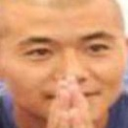

In [ ]:
X_train[9]

In [ ]:
X_train_scaled[0]

array([[[0.96078431, 0.96078431, 0.96078431],
        [0.96078431, 0.96078431, 0.96078431],
        [0.96078431, 0.96078431, 0.96078431],
        ...,
        [0.95686275, 0.95686275, 0.95686275],
        [0.95686275, 0.95686275, 0.95686275],
        [0.95686275, 0.95686275, 0.95686275]],

       [[0.96078431, 0.96078431, 0.96078431],
        [0.96078431, 0.96078431, 0.96078431],
        [0.96078431, 0.96078431, 0.96078431],
        ...,
        [0.95686275, 0.95686275, 0.95686275],
        [0.95686275, 0.95686275, 0.95686275],
        [0.95686275, 0.95686275, 0.95686275]],

       [[0.96078431, 0.96078431, 0.96078431],
        [0.96078431, 0.96078431, 0.96078431],
        [0.96078431, 0.96078431, 0.96078431],
        ...,
        [0.95686275, 0.95686275, 0.95686275],
        [0.95686275, 0.95686275, 0.95686275],
        [0.95686275, 0.95686275, 0.95686275]],

       ...,

       [[0.97254902, 0.97254902, 0.97254902],
        [0.97254902, 0.97254902, 0.97254902],
        [0.97254902, 0

**Building a Convolutional Neural Networks (CNN)**

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
num_of_classes = 2

model = keras.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)))

model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))


model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))


model.add(keras.layers.Dense(2, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])

In [ ]:
# training the neural network
history = model.fit(X_train_scaled, Y_train, validation_split=0.1, epochs=5)

Epoch 1/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - acc: 0.6560 - loss: 0.6609 - val_acc: 0.8793 - val_loss: 0.2956
Epoch 2/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - acc: 0.8778 - loss: 0.3196 - val_acc: 0.9124 - val_loss: 0.2099
Epoch 3/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - acc: 0.9019 - loss: 0.2435 - val_acc: 0.9174 - val_loss: 0.1987
Epoch 4/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - acc: 0.9184 - loss: 0.2043 - val_acc: 0.9107 - val_loss: 0.2213
Epoch 5/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - acc: 0.9363 - loss: 0.1619 - val_acc: 0.9140 - val_loss: 0.2042


**Model Evaluation**

In [ ]:
loss, accuracy = model.evaluate(X_test_scaled, Y_test)
print('Test Accuracy =', accuracy)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - acc: 0.9175 - loss: 0.2214
Test Accuracy = 0.9139642715454102


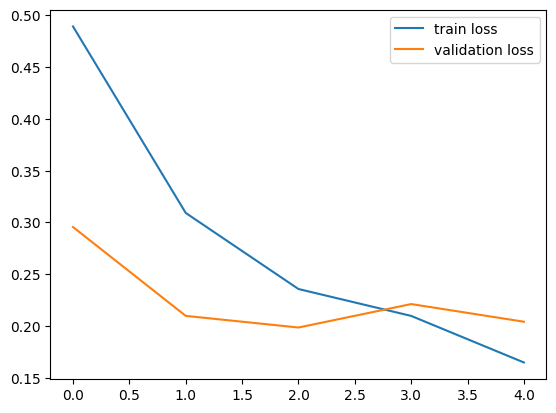

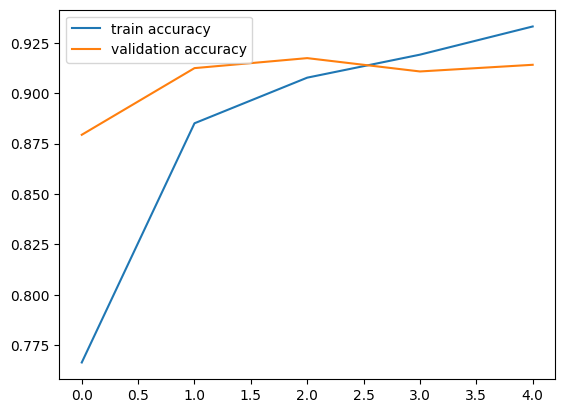

In [ ]:
h = history

# plot the loss value
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

# plot the accuracy value
plt.plot(h.history['acc'], label='train accuracy')
plt.plot(h.history['val_acc'], label='validation accuracy')
plt.legend()
plt.show()

In [ ]:
print(model.input_shape)

(None, 128, 128, 3)


**Predictive System**

Path of the image to be predicted: /content/1_jpg.rf.63d85e1c020e199b8b0c7da817129314.jpg


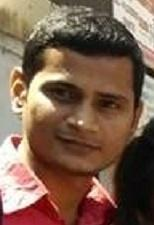

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[0.9827229  0.03321135]]
0
The person in the image is not wearing a mask


In [ ]:
input_image_path = input('Path of the image to be predicted: ')

input_image = cv2.imread(input_image_path)

cv2_imshow(input_image)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
input_image_resized = cv2.resize(input_image, (128, 128))



input_image_scaled = input_image_resized/255.0
input_image_scaled = np.expand_dims(input_image_scaled, axis=0)

input_image_reshaped = np.reshape(input_image_scaled, [1,128,128,3])

input_prediction = model.predict(input_image_reshaped)


print(input_prediction)

input_pred_label= np.argmax(input_prediction)

print(input_pred_label)



if input_pred_label == 1:

  print('The person in the image is wearing a mask')

else:

  print('The person in the image is not wearing a mask')